In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from collections import Counter

In [4]:
class PCA:
    def __init__(self, n_components):
        self.n_components = n_components
        self.components = None
        self.mean = None

    def fit(self, X):
        # Compute mean of the data
        self.mean = np.mean(X, axis=0)
        
        # Center the data
        X = X - self.mean
        
        # Compute covariance matrix
        cov_matrix = np.cov(X.T)
        
        # Perform eigendecomposition
        eigenvalues, eigenvectors = np.linalg.eig(cov_matrix)
        
        # Sort eigenvectors based on eigenvalues
        eigenvectors = eigenvectors.T
        idxs = np.argsort(eigenvalues)[::-1]
        eigenvectors = eigenvectors[idxs]
        
        # Store the first n_components components
        self.components = eigenvectors[0:self.n_components]

    def transform(self, X):
        # Center the data
        X = X - self.mean
        
        # Project the data onto the principal components
        return np.dot(X, self.components.T)

In [37]:
class LDA:
    def __init__(self, n_components=None):
        self.n_components = n_components
        self.eigenvalues = None
        self.eigenvectors = None

    def fit(self, X, y):
        n_features = X.shape[1]
        classes = np.unique(y)
        n_classes = len(classes)
        
        mean_overall = np.mean(X, axis=0)
        within_class_scatter = np.zeros((n_features, n_features))
        between_class_scatter = np.zeros((n_features, n_features))

        for c in classes:
            X_class = X[y == c]
            mean_class = np.mean(X_class, axis=0)
            mean_diff = (mean_class - mean_overall).reshape(-1, 1)
            within_class_scatter += np.dot((X_class - mean_class).T, X_class - mean_class)
            between_class_scatter += X_class.shape[0] * np.dot(mean_diff, mean_diff.T)

        eigenvalues, eigenvectors = np.linalg.eig(np.linalg.inv(within_class_scatter).dot(between_class_scatter))
        eigenvectors = eigenvectors[:, np.argsort(eigenvalues)[::-1]]
        eigenvalues = eigenvalues[np.argsort(eigenvalues)[::-1]]

        self.eigenvalues = eigenvalues[:self.n_components]
        self.eigenvectors = eigenvectors[:, :self.n_components]

    def transform(self, X):
        return np.dot(X, np.real(self.eigenvectors))

    def fit_transform(self, X, y):
        self.fit(X, y)
        return self.transform(X)


In [4]:
def train_test_split(X, y, split_ratio=0.7, random_state=None):
    if random_state:
        np.random.seed(random_state)
    
    # Shuffle the dataset
    shuffle_idx = np.random.permutation(len(X))
    X = X[shuffle_idx]
    y = y[shuffle_idx]
    
    # Split the dataset into training and testing sets
    split_idx = int(len(X) * split_ratio)
    X_train, X_test = X[:split_idx], X[split_idx:]
    y_train, y_test = y[:split_idx], y[split_idx:]
    
    return X_train, X_test, y_train, y_test


In [5]:
class LogisticRegression:
    def __init__(self, learning_rate=0.01, num_iterations=1000):
        self.learning_rate = learning_rate
        self.num_iterations = num_iterations
        self.weights = None
        self.bias = None
    
    def sigmoid(self, z):
        return 1 / (1 + np.exp(-z))

    def initialize_weights(self, num_features):
        # Initialize weights for features and bias separately
        np.random.seed(42)
        self.weights = np.random.rand(num_features)
        self.bias = np.random.rand()

    def fit(self, X, y):
        num_samples, num_features = X.shape
        self.initialize_weights(num_features)  # Initialize weights and bias
        
        for _ in range(self.num_iterations):
            predictions = self._predict(X)
            error = y - predictions
            gradient_weights = np.dot(X.T, error) / num_samples  # Gradient for weights 
            gradient_bias = np.mean(error)  # Gradient for bias
            
            # Update weights and bias
            self.weights += self.learning_rate * gradient_weights
            self.bias += self.learning_rate * gradient_bias
    
    def _predict(self, X):
        return self.sigmoid(np.dot(X, self.weights) + self.bias)

    def predict(self, X, threshold=0.5):
        predictions = self._predict(X)
        return np.where(predictions >= threshold, 1, 0)

    def accuracy_score(self, y_true, y_pred):
        return np.mean(y_true == y_pred)


In [6]:
class KNearestNeighbors:
    def __init__(self, k=3):
        self.k = k

    def fit(self, X_train, y_train):
        self.X_train = X_train
        self.y_train = y_train

    def predict(self, X_test):
        predictions = [self._predict(x) for x in X_test]
        return np.array(predictions)

    def _predict(self, x):
        # Compute the distances between x and all examples in the training set
        distances = [self._euclidean_distance(x, x_train) for x_train in self.X_train]
        # Sort by distance and return indices of the first k neighbors
        k_indices = np.argsort(distances)[:self.k]
        # Extract the labels of the k nearest neighbor training samples
        k_nearest_labels = [self.y_train[i] for i in k_indices]
        # Return the most common class label
        most_common = Counter(k_nearest_labels).most_common(1)
        return most_common[0][0]

    def _euclidean_distance(self, x1, x2):
        return np.sqrt(np.sum((x1 - x2) ** 2))

In [74]:
class GeneticAlgorithmFeatureSelection:
    def __init__(self, X_train, X_test, y_train, y_test, classifier, population_size=10, num_generations=10, mutation_rate=0.05):
        self.X_train = X_train
        self.X_test = X_test
        self.y_train = y_train
        self.y_test = y_test
        self.classifier = classifier  # Store the classifier instance
        self.population_size = population_size
        self.num_generations = num_generations
        self.mutation_rate = mutation_rate
        self.population = None
        self.fitness_scores = None

    def initialize_population(self):
        self.population = np.random.randint(2, size=(self.population_size, self.X_train.shape[1]))

    def fitness(self, features):
        # Selecting the features that are marked as 1 (i.e., used for the model)
        feature_indices = np.where(features == 1)[0]
        if len(feature_indices) == 0:  # Avoid training a model with no features
            return 0
        X_train_subset = self.X_train[:, feature_indices]
        X_test_subset = self.X_test[:, feature_indices]
        self.classifier.fit(X_train_subset, self.y_train)
        y_pred = self.classifier.predict(X_test_subset)

        return np.mean(y_pred == self.y_test)

    def evaluate_population(self):
        self.fitness_scores = [self.fitness(individual) for individual in self.population]

    def select_parents(self):
        parent_indices = np.random.choice(self.population_size, size=self.population_size, replace=True,
                                          p=self.fitness_scores / np.sum(self.fitness_scores))
        return self.population[parent_indices]

    def crossover(self, parents):
        children = np.empty_like(parents)
        for i in range(self.population_size):
            parent1 = parents[i]
            parent2 = parents[np.random.randint(self.population_size)]
            crossover_point = np.random.randint(1, self.X_train.shape[1] - 1)
            children[i] = np.concatenate((parent1[:crossover_point], parent2[crossover_point:]))
        return children

    def mutate(self, children):
        for i in range(self.population_size):
            if np.random.rand() < self.mutation_rate:
                mutation_point = np.random.randint(self.X_train.shape[1])
                children[i, mutation_point] = 1 - children[i, mutation_point]
        return children

    def fit(self):
        self.initialize_population()
        self.evaluate_population()

        for generation in range(self.num_generations):
            parents = self.select_parents()
            children = self.crossover(parents)
            mutated_children = self.mutate(children)
            self.population = mutated_children
            self.evaluate_population()

        best_features = self.population[np.argmax(self.fitness_scores)]
        return best_features


In [7]:
df = pd.read_csv("/kaggle/input/cancer-data/Cancer_Data.csv")
df.head()

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,radius_se,texture_se,perimeter_se,area_se,smoothness_se,compactness_se,concavity_se,concave points_se,symmetry_se,fractal_dimension_se,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,Unnamed: 32
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,1.0950,0.9053,8.589,153.40,0.006399,0.04904,0.05373,0.01587,0.03003,0.006193,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,NaN
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,0.5435,0.7339,3.398,74.08,0.005225,0.01308,0.01860,0.01340,0.01389,0.003532,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,NaN
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,0.7456,0.7869,4.585,94.03,0.006150,0.04006,0.03832,0.02058,0.02250,0.004571,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,NaN
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,0.4956,1.1560,3.445,27.23,0.009110,0.07458,0.05661,0.01867,0.05963,0.009208,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,NaN
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,0.7572,0.7813,5.438,94.44,0.011490,0.02461,0.05688,0.01885,0.01756,0.005115,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,NaN


In [8]:
df.shape

(569, 33)

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 33 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   id                       569 non-null    int64  
 1   diagnosis                569 non-null    object 
 2   radius_mean              569 non-null    float64
 3   texture_mean             569 non-null    float64
 4   perimeter_mean           569 non-null    float64
 5   area_mean                569 non-null    float64
 6   smoothness_mean          569 non-null    float64
 7   compactness_mean         569 non-null    float64
 8   concavity_mean           569 non-null    float64
 9   concave points_mean      569 non-null    float64
 10  symmetry_mean            569 non-null    float64
 11  fractal_dimension_mean   569 non-null    float64
 12  radius_se                569 non-null    float64
 13  texture_se               569 non-null    float64
 14  perimeter_se             5

In [9]:
df.drop(["Unnamed: 32", "id"], axis=1, inplace=True)

In [10]:
# separate the data to X and y
X = df.drop("diagnosis" , axis =1)
y = df["diagnosis"]

# Mapping the values in y to 0 and 1
y = np.where(y == 'B', 0, 1)

0    357
1    212
Name: count, dtype: int64


<Axes: >

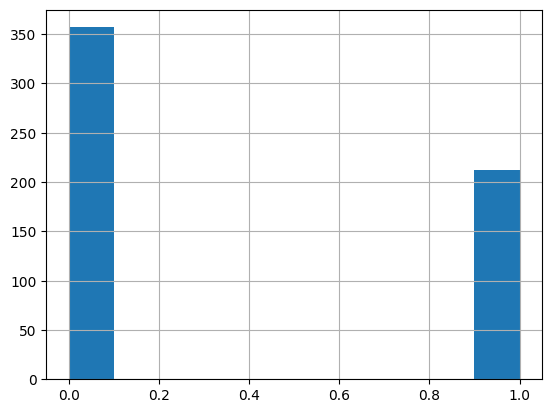

In [50]:
# Count the values of classes
y_series = pd.Series(y)
print(y_series.value_counts())

y_series.hist()

In [11]:
# Split the data to Train set and Test set
X = np.array(X)
X_train, X_test, y_train, y_test = train_test_split(X, y, split_ratio=0.7, random_state=40)

# Apply Logistic Regression and K-Nearest Neighbors on the dataset

In [71]:
# Initialize and train the LogisticRegression classifier
clf = LogisticRegression()
clf.fit(X_train, y_train)

# Make predictions
y_pred = clf.predict(X_test)

# Calculate accuracy
accuracy = np.mean(y_test == y_pred)
print(f"Accuracy of LogisticRegression: {accuracy * 100:.2f}%")
######################################################################3

# Initialize and train the k-NN classifier
knn = KNearestNeighbors(k=10)
knn.fit(X_train, y_train)

# Make predictions
predictions = knn.predict(X_test)

# Evaluate accuracy
accuracy = np.mean(predictions == y_test)
print(f"Accuracy of KNN: {accuracy * 100:.2f}%")

/tmp/ipykernel_550/1745372544.py:9: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-z))


Accuracy of LogisticRegression: 91.81%
Accuracy of KNN: 95.91%


# Apply Logistic Regression and K-Nearest Neighbors after applying PCA 

In [85]:
pca = PCA(n_components=25)
pca.fit(X_train)
# Train data
X_transformed_train = pca.transform(X_train)

# Test data
X_transformed_test = pca.transform(X_test)

In [86]:
# Initialize and train the LogisticRegression classifier

clf = LogisticRegression()
clf.fit(X_transformed_train, y_train)

# Make predictions
y_pred = clf.predict(X_transformed_test)

# Calculate accuracy
accuracy = np.mean(y_test == y_pred)

print(f"Accuracy of LogisticRegression: {accuracy * 100:.2f}%")
##########################################################

# Initialize and train the k-NN classifier
knn = KNearestNeighbors(k=10)
knn.fit(X_transformed_train, y_train)

# Make predictions
predictions = knn.predict(X_transformed_test)

# Evaluate accuracy
accuracy = np.mean(predictions == y_test)
print(f"Accuracy of KNN: {accuracy * 100:.2f}%")

/tmp/ipykernel_550/1745372544.py:9: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-z))


Accuracy of LogisticRegression: 97.08%
Accuracy of KNN: 95.91%


# Apply Logistic Regression and K-Nearest Neighbors after applying LDA 

In [52]:
lda = LDA(n_components=10)

# Fit the LDA model on the training data
lda.fit(X_train, y_train)

# Transform the training data
X_transformed_LDA_train = lda.transform(X_train)

# Transform the test data
X_transformed_LDA_test = lda.transform(X_test)

In [53]:
# Initialize and train the LogisticRegression classifier

clf = LogisticRegression()
clf.fit(X_transformed_LDA_train, y_train)

# Make predictions
y_pred = clf.predict(X_transformed_LDA_test)

# Calculate accuracy
accuracy = np.mean(y_test == y_pred)

print(f"Accuracy of LogisticRegression: {accuracy * 100:.2f}%")
##########################################################

# Initialize and train the k-NN classifier
knn = KNearestNeighbors(k=10)
knn.fit(X_transformed_LDA_train, y_train)

# Make predictions
predictions = knn.predict(X_transformed_LDA_test)

# Evaluate accuracy
accuracy = np.mean(predictions == y_test)
print(f"Accuracy of KNN: {accuracy * 100:.2f}%")

Accuracy of LogisticRegression: 60.82%
Accuracy of KNN: 96.49%


## Apply Logistic Regression and K-Nearest Neighbors after making feature selection using Genetic Algorithm

In [81]:
clf = LogisticRegression()

ga = GeneticAlgorithmFeatureSelection(X_scaled_train, X_scaled_test, y_train, y_test, classifier=clf, population_size=30, num_generations=30, mutation_rate=0.05)
best_features = ga.fit()

# Get the selected features
X_train_subset = X_scaled_train[:, best_features.astype(bool)]
X_test_subset = X_scaled_test[:, best_features.astype(bool)]
print("Selected features: ", best_features)
print("NO. of Selected features: ", np.sum(best_features))

# Train and evaluate the LogisticRegression on the selected features
clf.fit(X_train_subset, y_train)
y_pred = clf.predict(X_test_subset)
accuracy = np.mean(y_pred == y_test)
print(f"Accuracy of LogisticRegression: {accuracy * 100:.2f}%")


/tmp/ipykernel_550/1745372544.py:9: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-z))


Selected features:  [1 1 1 1 0 0 1 1 1 0 0 1 1 1 1 1 1 1 1 0 1 0 1 1 0 1 0 1 1 1]
NO. of Selected features:  22
Accuracy of LogisticRegression: 85.96%


In [82]:
clf = KNearestNeighbors(k=10)

ga = GeneticAlgorithmFeatureSelection(X_scaled_train, X_scaled_test, y_train, y_test, classifier=clf, population_size=30, num_generations=30, mutation_rate=0.05)
best_features = ga.fit()

# Get the selected features
X_train_subset = X_scaled_train[:, best_features.astype(bool)]
X_test_subset = X_scaled_test[:, best_features.astype(bool)]
print("Selected features: ", best_features)
print("NO. of Selected features: ", np.sum(best_features))
# Train and evaluate the K-Nearest Neighbors on the selected features
clf.fit(X_train_subset, y_train)
y_pred = clf.predict(X_test_subset)
accuracy = np.mean(y_pred == y_test)

print(f"Accuracy of KNN: {accuracy * 100:.2f}%")

Selected features:  [1 1 1 1 0 1 0 0 0 0 1 1 1 1 0 0 0 1 1 0 1 1 1 1 1 1 0 1 0 0]
NO. of Selected features:  18
Accuracy of KNN: 93.57%
